In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re
from dataclasses import dataclass
import yaml
import cv2
import math
import torch

# Manual Projection

Project an existing model.

In [2]:
MODEL_PATH = "out_model/saved_models/resnet18/good_proto3_trial_8/7nopush0.8009.pth"
model = torch.load(MODEL_PATH)
model = torch.nn.DataParallel(model)
model

/tmp/ipykernel_3978798/2085258307.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(MODEL_PATH)


DataParallel(
  (module): PPNet(
  	features: resnet18_features,
  	img_size: 512,
  	prototype_shape: (120, 64, 3, 3),
  	proto_layer_rf_info: [14, 32, 499, 32.5],
  	num_classes: 2,
  	epsilon: 0.0001
  )
)

In [3]:
config_file = "./configs/unet_segment_newdata.yaml"
with open(config_file, "r") as stream:
    conf = yaml.safe_load(stream)

In [4]:
from src.data.raman_dataset import create_raman_mask_dataloaders_from_ids

train_push_dl = create_raman_mask_dataloaders_from_ids(
    conf["data"]["train_ids"],
    conf,
    transforms=None,
    shuffle=False,
    is_train=True,
    be_fast=False,
)

In [5]:
val_conf = conf.copy()
val_conf["data"]["extra_filtering"] = []
val_conf["training"]["stride"] = val_conf["training"]["patch_size"]
val_dl = create_raman_mask_dataloaders_from_ids(
    val_conf["data"]["val_ids"],
    val_conf,
    shuffle=False,
    is_train=False,
    be_fast=False,
)

In [6]:
from src.training import train_and_test as tnt

accu = tnt.test(
    model=model,
    dataloader=val_dl,
)

	test
	time: 	17.431681871414185
	cross ent: 	2.4298222008205594
	diversity: 	0.0015545222586730407
	dice loss: 	0.3494422918274289
	accu: 		80.08624712626138%
	l1: 		180.0
	p dist pair: 	5.235008716583252


In [7]:
from src.training import push

push.push_prototypes(
    train_push_dl,
    prototype_network_parallel=model,
)

	push
	Executing push ...
	Prototype 0: min distance = 0.8824
	Prototype 1: min distance = 0.8921
	Prototype 2: min distance = 0.8702
	Prototype 3: min distance = 0.8614
	Prototype 4: min distance = 0.7844
	Prototype 5: min distance = 0.8056
	Prototype 6: min distance = 0.9140
	Prototype 7: min distance = 0.8464
	Prototype 8: min distance = 0.8351
	Prototype 9: min distance = 0.8988
	Prototype 10: min distance = 0.9006
	Prototype 11: min distance = 0.8699
	Prototype 12: min distance = 0.9059
	Prototype 13: min distance = 0.8877
	Prototype 14: min distance = 0.8565
	Prototype 15: min distance = 0.9161
	Prototype 16: min distance = 0.8535
	Prototype 17: min distance = 0.9778
	Prototype 18: min distance = 0.8936
	Prototype 19: min distance = 0.8864
	Prototype 20: min distance = 0.8739
	Prototype 21: min distance = 0.8975
	Prototype 22: min distance = 0.8045
	Prototype 23: min distance = 0.9007
	Prototype 24: min distance = 0.8616
	Prototype 25: min distance = 0.8855
	Prototype 26: min dis

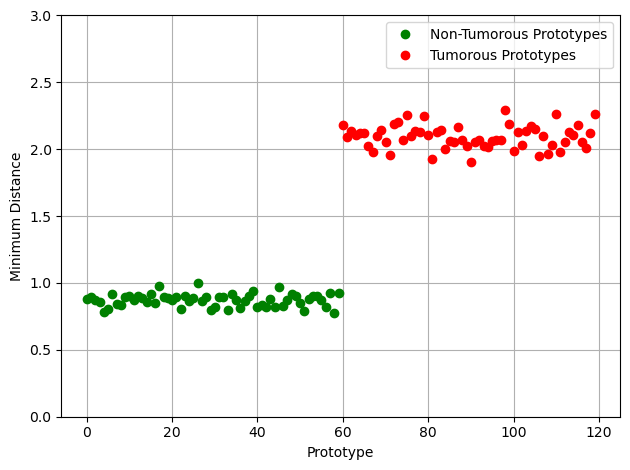

In [59]:
prototype_ids = list(range(120))
min_distances = [
    0.8824, 0.8921, 0.8702, 0.8614, 0.7844, 0.8056, 0.9140, 0.8464, 0.8351, 0.8988,
    0.9006, 0.8699, 0.9059, 0.8877, 0.8565, 0.9161, 0.8535, 0.9778, 0.8936, 0.8864,
    0.8739, 0.8975, 0.8045, 0.9007, 0.8616, 0.8855, 0.9987, 0.8682, 0.8981, 0.7954,
    0.8167, 0.8921, 0.8944, 0.7958, 0.9206, 0.8748, 0.8127, 0.8658, 0.9029, 0.9395,
    0.8182, 0.8361, 0.8211, 0.8801, 0.8170, 0.9665, 0.8258, 0.8718, 0.9191, 0.9033,
    0.8492, 0.7927, 0.8823, 0.9000, 0.9044, 0.8696, 0.8219, 0.9281, 0.7769, 0.9233,
    2.1839, 2.0913, 2.1364, 2.1099, 2.1239, 2.1217, 2.0235, 1.9810, 2.0967, 2.1419,
    2.0545, 1.9588, 2.1894, 2.2024, 2.0695, 2.2576, 2.0972, 2.1327, 2.1256, 2.2513,
    2.1075, 1.9261, 2.1293, 2.1409, 2.0040, 2.0618, 2.0578, 2.1643, 2.0667, 2.0275,
    1.9025, 2.0520, 2.0670, 2.0278, 2.0171, 2.0623, 2.0666, 2.0709, 2.2925, 2.1860,
    1.9843, 2.1310, 2.0320, 2.1381, 2.1718, 2.1495, 1.9504, 2.1020, 1.9641, 2.0352,
    2.2623, 1.9778, 2.0565, 2.1265, 2.1071, 2.1831, 2.0539, 2.0086, 2.1236, 2.2667
]

# plt.plot(prototype_ids, min_distances, 'o')
plt.plot(prototype_ids[:60], min_distances[:60], 'o', color='green', label='Non-Tumorous Prototypes')
plt.plot(prototype_ids[60:], min_distances[60:], 'o', color='red', label='Tumorous Prototypes')
plt.legend()
plt.xlabel('Prototype')
plt.ylabel('Minimum Distance')
plt.ylim(0, 3)
plt.grid(True)
plt.tight_layout()
plt.show()

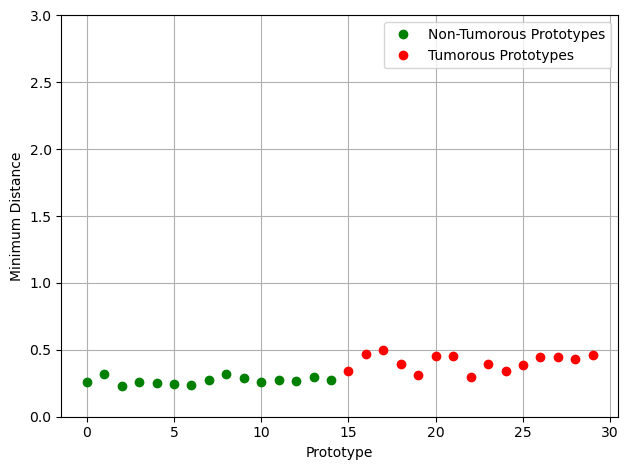

In [61]:
projection_distances = [
    0.2587, 0.3166, 0.2328, 0.2573, 0.2540, 0.2451, 0.2386, 0.2710,
    0.3218, 0.2900, 0.2599, 0.2772, 0.2687, 0.2988, 0.2767, 0.3402,
    0.4706, 0.4971, 0.3948, 0.3104, 0.4542, 0.4535, 0.2981, 0.3951,
    0.3396, 0.3838, 0.4436, 0.4442, 0.4301, 0.4647,
]
# plt.figure(figsize=(15, 6))
plt.plot(list(range(15)), projection_distances[:15], 'o', color='green', label='Non-Tumorous Prototypes')
plt.plot(list(range(15, 30)), projection_distances[15:], 'o', color='red', label='Tumorous Prototypes')
plt.legend()
plt.xlabel('Prototype')
plt.ylabel('Minimum Distance')
plt.ylim(0, 3)
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
from src.training import train_and_test as tnt

accu = tnt.test(
    model=model,
    dataloader=val_dl,
)

	test
	time: 	52.21011829376221
	cross ent: 	4.88907866250901
	diversity: 	0.0014994741040503694
	dice loss: 	0.44858563797814505
	accu: 		68.56920151483446%
	l1: 		180.0
	p dist pair: 	13.91855239868164


In [45]:
# save model
temp_model_path = f"prototypes/model_{accu:.4f}.pth"
torch.save(obj=model, f=temp_model_path)

# Prototype Viz

In [14]:
PROTOTYPE_PATH = "prototypes/"
HNE_PATH = "/home/ct678/code/charm_data/aligned_hne"
MASK_PATH = "/home/ct678/aligned_masks"

In [15]:
prototype_paths = list(sorted(os.path.join(PROTOTYPE_PATH, filename) for filename in os.listdir(PROTOTYPE_PATH) if filename.endswith('.npz')))
num_prototypes = len(prototype_paths)
print(f"Found {num_prototypes} prototype files.")

Found 120 prototype files.


In [16]:
prototypes = []
for prototype_path in tqdm(prototype_paths, desc="Loading prototypes"):
    data = np.load(prototype_path, mmap_mode='r')['region']
    prototypes.append(data)
prototypes = np.stack(prototypes)
prototypes.shape

Loading prototypes: 100%|██████████| 120/120 [02:10<00:00,  1.09s/it]


(120, 512, 512, 24)

In [17]:
def compute_mean_intensities(prototype):
    channel_wise_mean = np.mean(prototype, axis=(0, 1))
    channel_wise_std = np.std(prototype, axis=(0, 1))
    return channel_wise_mean, channel_wise_std

In [18]:
# trivial prototypes if mostly zeros
trivial_prototypes = sum(1 for p in prototypes if np.count_nonzero(p) < 0.01 * p.size)
print(f"Number of trivial prototypes (mostly zeros): {trivial_prototypes}")

Number of trivial prototypes (mostly zeros): 16


In [19]:
flattened_prototypes = prototypes[:, :, :, 21].reshape(num_prototypes, -1)
flattened_prototypes.shape

(120, 262144)

In [20]:
config_file = "./configs/unet_segment_newdata.yaml"
with open(config_file, "r") as stream:
    conf = yaml.safe_load(stream)
train_ids = conf['data']['train_ids']

In [21]:
@dataclass
class BoundingBox:
    index: int
    bounds: list[int]

In [22]:
bounding_box_data = []
with open(os.path.join(PROTOTYPE_PATH, "prototype_bounds.txt"), 'r') as f:
    for s in f:
        index_match = re.search(r'index=(\d+)', s)
        index = int(index_match.group(1)) if index_match else None

        # Extract bounds
        bounds_match = re.search(r'bounds=\[([^\]]+)\]', s)
        bounds = list(map(int, bounds_match.group(1).split(','))) if bounds_match else None
        bounding_box = BoundingBox(index=index, bounds=bounds)
        bounding_box_data.append(bounding_box)

# Helpers

In [23]:
def patchify(big_img, patch_size, stride):
    # h, w, c = big_img.shape
    ph, pw = patch_size
    sh, sw = stride
    tmp_img = big_img.unfold(0, ph, sh).unfold(1, pw, sw)  # N1, N2, C, H, W
    tmp_img = tmp_img.reshape(
        tmp_img.shape[0] * tmp_img.shape[1], tmp_img.shape[2], ph, pw
    )
    return tmp_img

In [24]:
def expected_patchify_shape(big_img_shape, conf):
    h, w, c = big_img_shape
    ph, pw = conf['training']['patch_size']
    sh, sw = conf['training']['stride']
    # Calculate the number of patches along the height (N1)
    # N1 = floor((H - ph) / sh) + 1
    n1 = math.floor((h - ph) / sh) + 1
    # Calculate the number of patches along the width (N2)
    # N2 = floor((W - pw) / sw) + 1
    n2 = math.floor((w - pw) / sw) + 1
    # The final shape after reshape is (N1 * N2, C, ph, pw)
    num_patches = n1 * n2
    return (num_patches, c, ph, pw)

In [25]:
from functools import cache

@cache
def get_filtered_patches_shape_raman(raman_id, patch_size, stride):
    patient_id = raman_id.split('_')[0]
    raman_ref = np.load(f"/home/ct678/code/charm_data/{patient_id}/{raman_id}_SRS_corrected.npy", mmap_mode='r')
    patched_raman = patchify(torch.from_numpy(raman_ref), patch_size, stride)
    # filter out background patches
    all_zero = torch.all(patched_raman == 0, dim=(1, 2, 3))
    ids_to_include = torch.where(~all_zero)[0]
    patched_raman = patched_raman[ids_to_include]
    return patched_raman.shape, ids_to_include

In [26]:
def locate_sample_and_index(train_ids, bounding_box_index, conf):
    current_index_start = 0
    for train_id in tqdm(train_ids):
        patched_raman_shape, ids_to_include = get_filtered_patches_shape_raman(
            train_id, tuple(conf["training"]["patch_size"]), tuple(conf["training"]["stride"])
        )
        next_index_start = current_index_start + patched_raman_shape[0]
        if current_index_start <= bounding_box_index < next_index_start:
            located_sample = train_id
            index_within_sample = bounding_box_index - current_index_start
            return located_sample, index_within_sample, ids_to_include
        current_index_start = next_index_start
    raise ValueError(f"Bounding box index {bounding_box_index} not found in train IDs.")


In [27]:
def get_hne_bound(located_sample, index_within_sample, ids_to_include, bounding_box_bounds):
    hne_located = np.load(os.path.join(f"{HNE_PATH}", f"{located_sample}_align_hne.npy"), mmap_mode='r')
    hne_downsized = cv2.resize(hne_located, (hne_located.shape[1] // 2, hne_located.shape[0] // 2), interpolation=cv2.INTER_LINEAR)
    patched_hne = patchify(torch.from_numpy(hne_downsized), conf['training']['patch_size'], conf['training']['stride'])
    patched_hne = patched_hne[ids_to_include]

    selected_patch = patched_hne[index_within_sample]
    selected_bound = selected_patch[:, bounding_box_bounds[0]:bounding_box_bounds[1], bounding_box_bounds[2]:bounding_box_bounds[3]]
    return selected_bound.permute(1, 2, 0).numpy()  # Convert to HWC format for visualization

In [28]:
def get_mask_bound(located_sample, index_within_sample, ids_to_include, bounding_box_bounds):
    mask_path = np.load(os.path.join(f"{MASK_PATH}", f"{located_sample}.npy"), mmap_mode='r')
    mask_downsized = cv2.resize(mask_path, (mask_path.shape[1] // 2, mask_path.shape[0] // 2), interpolation=cv2.INTER_NEAREST)
    mask_downsized = np.expand_dims(mask_downsized, axis=-1)  # Add channel dimension
    patched_mask = patchify(torch.from_numpy(mask_downsized), conf['training']['patch_size'], conf['training']['stride'])
    patched_mask = patched_mask[ids_to_include]

    selected_patch = patched_mask[index_within_sample]
    selected_bound = selected_patch[:, bounding_box_bounds[0]:bounding_box_bounds[1], bounding_box_bounds[2]:bounding_box_bounds[3]]
    return selected_bound.permute(1, 2, 0).numpy()  # Convert to HWC format for visualization

# Mask Analysis

In [29]:
def class_presence(train_ids, prototype_bounding_box):
    # class ratios out of a maximum 15 classes
    class_ratios = []
    for bounding_box in prototype_bounding_box:
        located_sample, index_within_sample, ids_to_include = locate_sample_and_index(train_ids, bounding_box.index, conf)
        mask_bound = get_mask_bound(located_sample, index_within_sample, ids_to_include, bounding_box.bounds)
        classes = np.unique(mask_bound, return_counts=True)
        class_counts = dict(zip(classes[0], classes[1]))
        # default to 0 for classes not present
        class_ratio = {i: class_counts.get(i, 0) / mask_bound.size for i in range(15)}
        class_ratios.append(class_ratio)
    return class_ratios

In [30]:
class_ratios = class_presence(train_ids, bounding_box_data)
len(class_ratios)

  0%|          | 0/19 [00:00<?, ?it/s]/tmp/ipykernel_3978798/405317071.py:7: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1736238290654/work/torch/csrc/utils/tensor_numpy.cpp:206.)
  patched_raman = patchify(torch.from_numpy(raman_ref), patch_size, stride)
  5%|▌         | 1/19 [00:00<00:00, 9198.04it/s]


120

In [31]:
class_name_map = {
    0: "Unannotated",
    1: "Tumor",
    10: "Artifact",
    11: "Glandular Epithelium",
    12: "Respiratory Epithelium",
    13: "Squamous Epithelium",
}

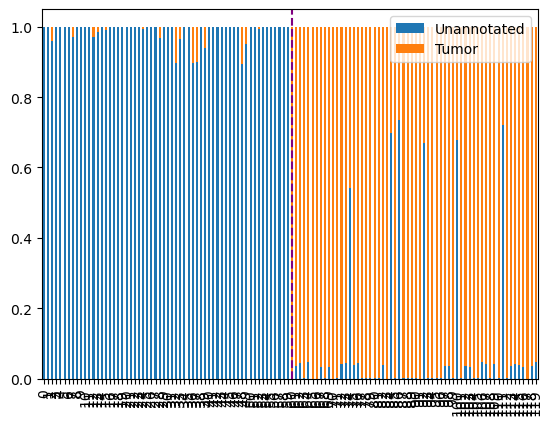

In [32]:
import pandas as pd
df = pd.DataFrame(class_ratios)
df.rename(columns=class_name_map, inplace=True)
filtered_cols = df.columns[df.sum() > 0]  # Filter out columns with no presence
ax = df[filtered_cols].plot(kind='bar', stacked=True)
# line to separate the prototypes
ax.axvline(x=len(class_ratios)/2, linestyle='--', color='purple')
plt.show()

# Protein Ratio

In [33]:
def high_protein_stats(patch):
    lipid_channel = 0 # about 2845
    cellular_channel = 10 # about 2930
    mean = patch.mean(axis=(0, 1))
    numerator = mean[cellular_channel]
    denominator = mean[cellular_channel] + mean[lipid_channel] + 1e-8
    return numerator / denominator if numerator >= 1e-3 else 0.0

In [34]:
protein_ratios = []
for prototype in prototypes:
    protein_ratio = high_protein_stats(prototype)
    protein_ratios.append(protein_ratio)

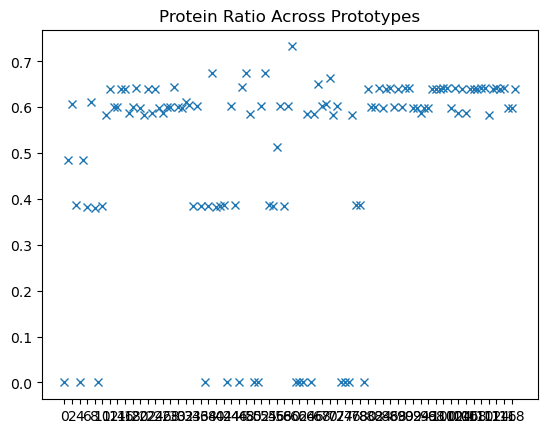

In [35]:
plt.plot(protein_ratios, 'x')
plt.title("Protein Ratio Across Prototypes")
plt.xticks(range(0, len(protein_ratios), 2))
plt.show()

# Prototype Clustering

100%|██████████| 26/26 [00:35<00:00,  1.38s/it]


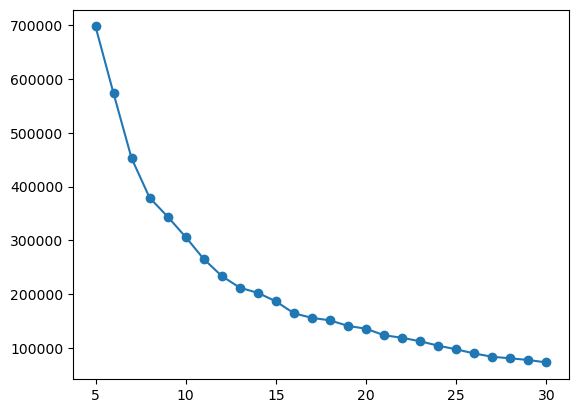

In [36]:
from sklearn.cluster import KMeans

inertia_values = []
possible_k_values = list(range(5, 31))
for k_val in tqdm(possible_k_values):
    kmeans = KMeans(n_clusters=k_val, random_state=42, n_init='auto')
    kmeans.fit(flattened_prototypes)
    inertia_values.append(kmeans.inertia_)
plt.plot(possible_k_values, inertia_values, marker='o')
plt.show()

In [37]:
k = 16
kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
kmeans.fit(flattened_prototypes)
labels = kmeans.labels_
labels[:labels.shape[0] // 2], labels[labels.shape[0] // 2:]

(array([11,  1,  3,  8,  5,  1, 14,  3, 14,  5,  4,  7,  1,  6,  6,  1,  1,
         6,  6,  1,  6,  9,  1,  7,  1,  6,  6,  6,  6,  1,  6,  6,  3,  0,
        12,  0,  4,  5,  4, 15, 12, 12,  2, 11,  0,  2,  5,  1, 15,  3,  7,
        11, 10, 15,  2,  4, 11, 10, 12, 10], dtype=int32),
 array([11,  5,  5,  5,  9,  5,  4, 15, 10,  3, 15,  9,  0, 13,  5, 13,  9,
         2,  8,  5,  1,  6,  6,  1,  6,  1,  1,  6,  1,  6,  1,  1,  6,  6,
         7,  6,  6,  1,  1,  1,  1,  1,  6,  1,  7,  1,  7,  1,  1,  1,  1,
         1,  7,  1,  1,  1,  1,  6,  6,  1], dtype=int32))

In [38]:
interesting_prototypes_i = [0, 1, 2, 3, 60, 61, 64, 66]
interesting_prototypes = [prototypes[i] for i in interesting_prototypes_i]

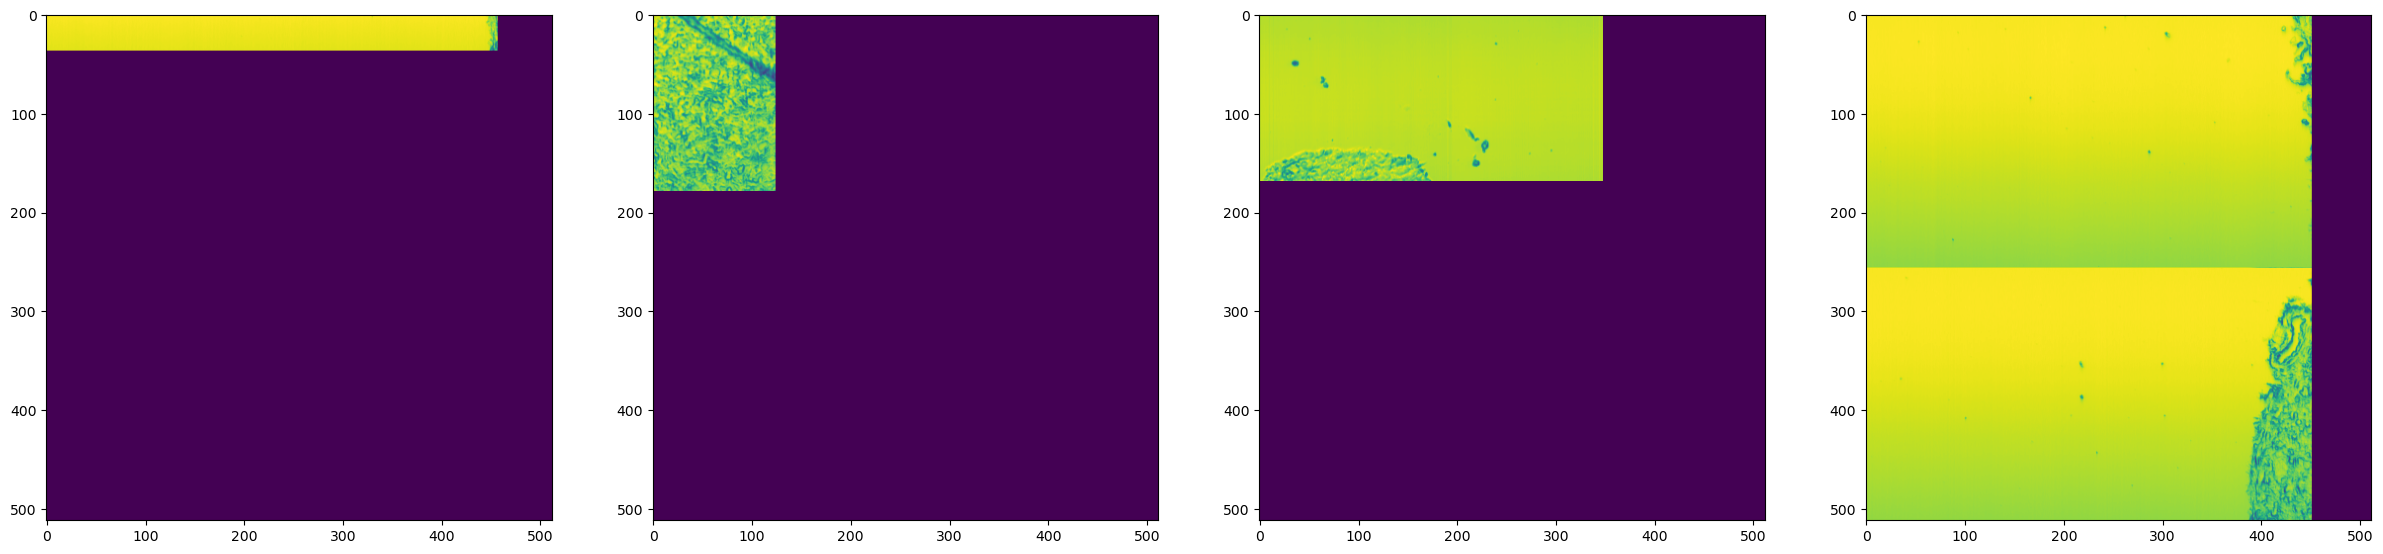

In [39]:
# plot side by side
fig, axes = plt.subplots(1, 4, figsize=(30, 20))
for i, proto in enumerate(interesting_prototypes[:4]):
    axes[i].imshow(proto[:, :, 21])
plt.show()

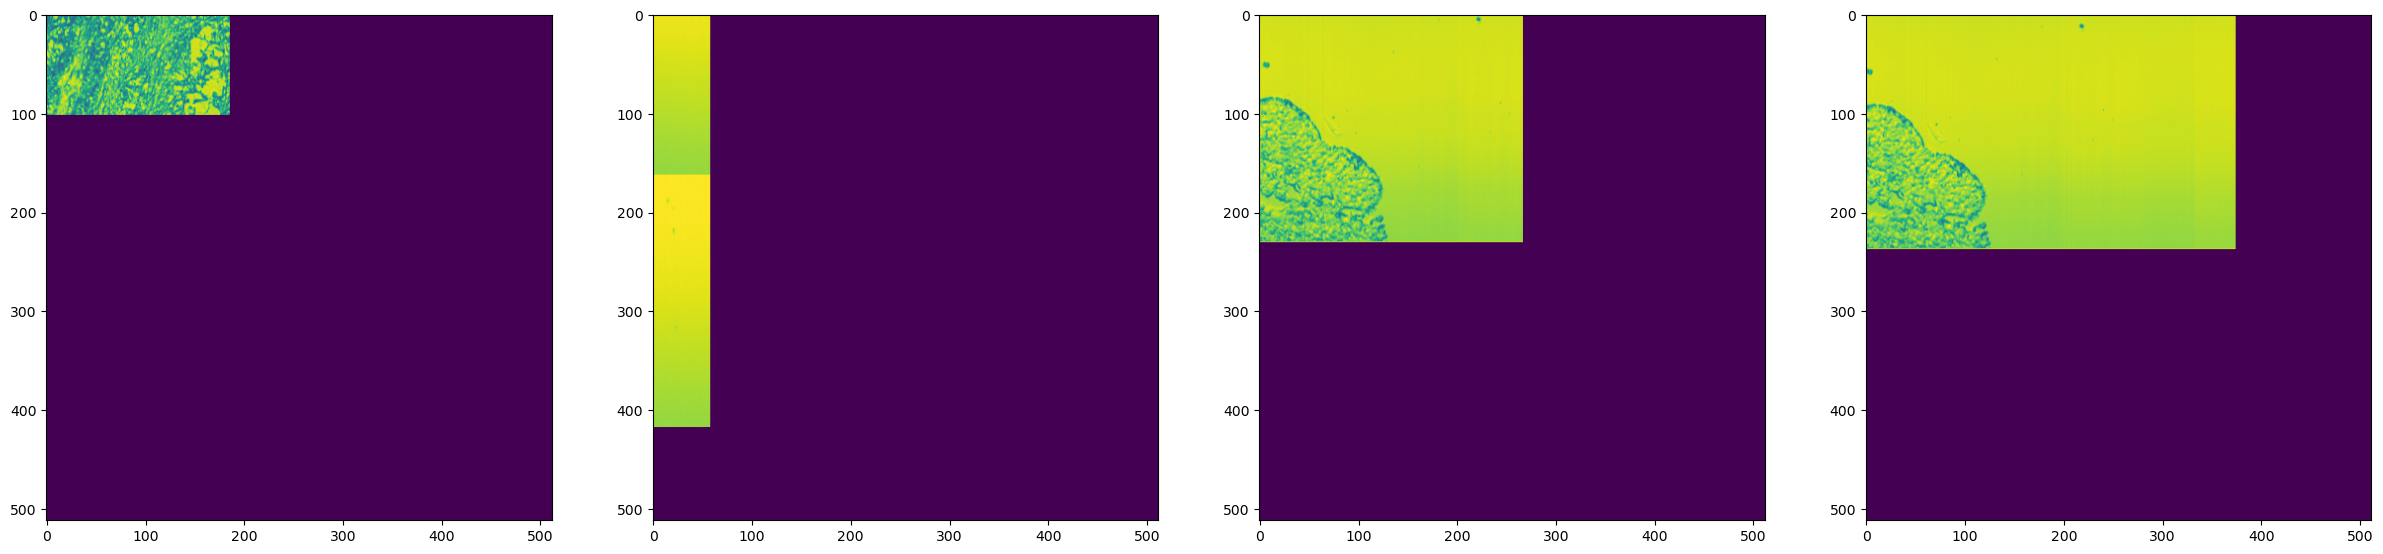

In [40]:
# plot side by side
fig, axes = plt.subplots(1, 4, figsize=(30, 20))
for i, proto in enumerate(interesting_prototypes[4:]):
    axes[i].imshow(proto[:, :, 21])
plt.show()

In [41]:
bounding_boxes_to_check = [bounding_box_data[i] for i in interesting_prototypes_i]
len(bounding_boxes_to_check)

8

# Mask Overlay

 32%|███▏      | 6/19 [00:00<00:00, 114390.11it/s]


(array([0], dtype=uint8), array([16909]))


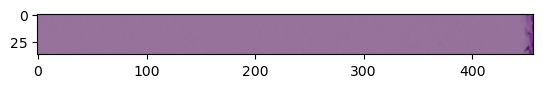

 21%|██        | 4/19 [00:00<00:00, 59705.40it/s]


(array([0], dtype=uint8), array([22196]))


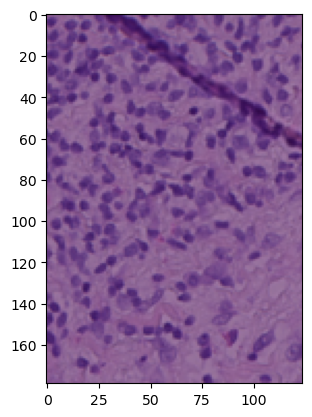

  0%|          | 0/19 [00:00<?, ?it/s]


(array([0, 1], dtype=uint8), array([56449,  2363]))


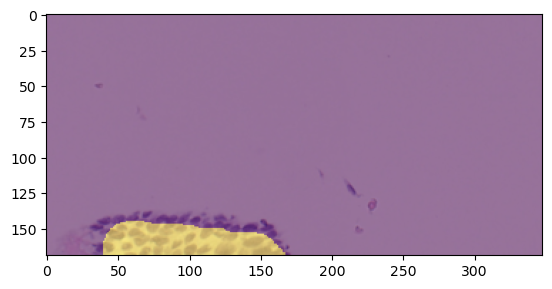

 32%|███▏      | 6/19 [00:00<00:00, 29676.68it/s]


(array([0], dtype=uint8), array([230912]))


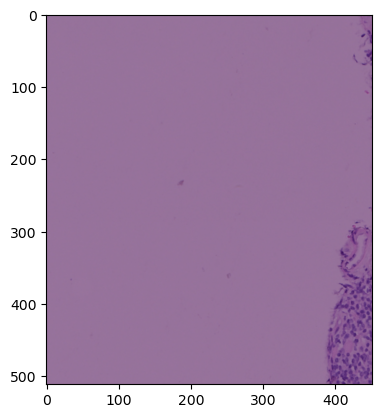

  5%|▌         | 1/19 [00:00<00:00, 17189.77it/s]


(array([0, 1], dtype=uint8), array([   28, 19789]))


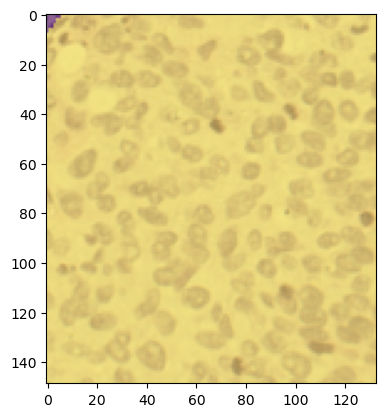

  5%|▌         | 1/19 [00:00<00:00, 5511.57it/s]


(array([0, 1], dtype=uint8), array([ 1089, 28803]))


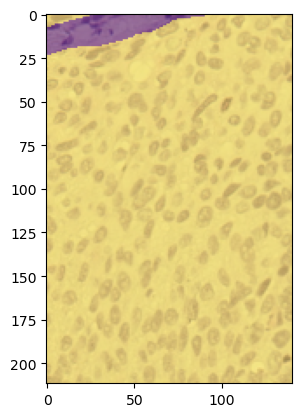

  5%|▌         | 1/19 [00:00<00:00, 22429.43it/s]


(array([0, 1], dtype=uint8), array([ 1432, 29453]))


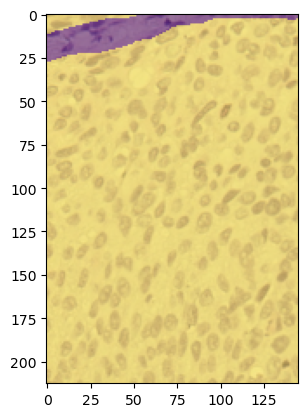

  5%|▌         | 1/19 [00:00<00:00, 20867.18it/s]


(array([0, 1], dtype=uint8), array([    7, 20405]))


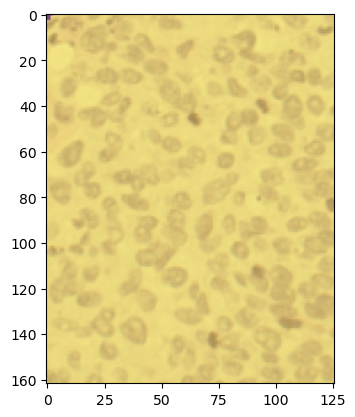

In [42]:
for bounding_box in bounding_boxes_to_check:
    bounding_box_index = bounding_box.index
    bounds = bounding_box.bounds
    located_sample, index_within_sample, ids_to_include = locate_sample_and_index(train_ids, bounding_box_index, conf)
    mask_bound = get_mask_bound(located_sample, index_within_sample, ids_to_include, bounds)
    print(np.unique(mask_bound, return_counts=True))
    hne_bound = get_hne_bound(located_sample, index_within_sample, ids_to_include, bounds)
    plt.imshow(hne_bound)
    plt.imshow(mask_bound, alpha=0.5)
    plt.show()

# Spectral Differences

In [43]:
def channel_stats(patch):
    mean = np.mean(patch, axis=(0, 1))
    std = np.std(patch, axis=(0, 1))
    return mean, std

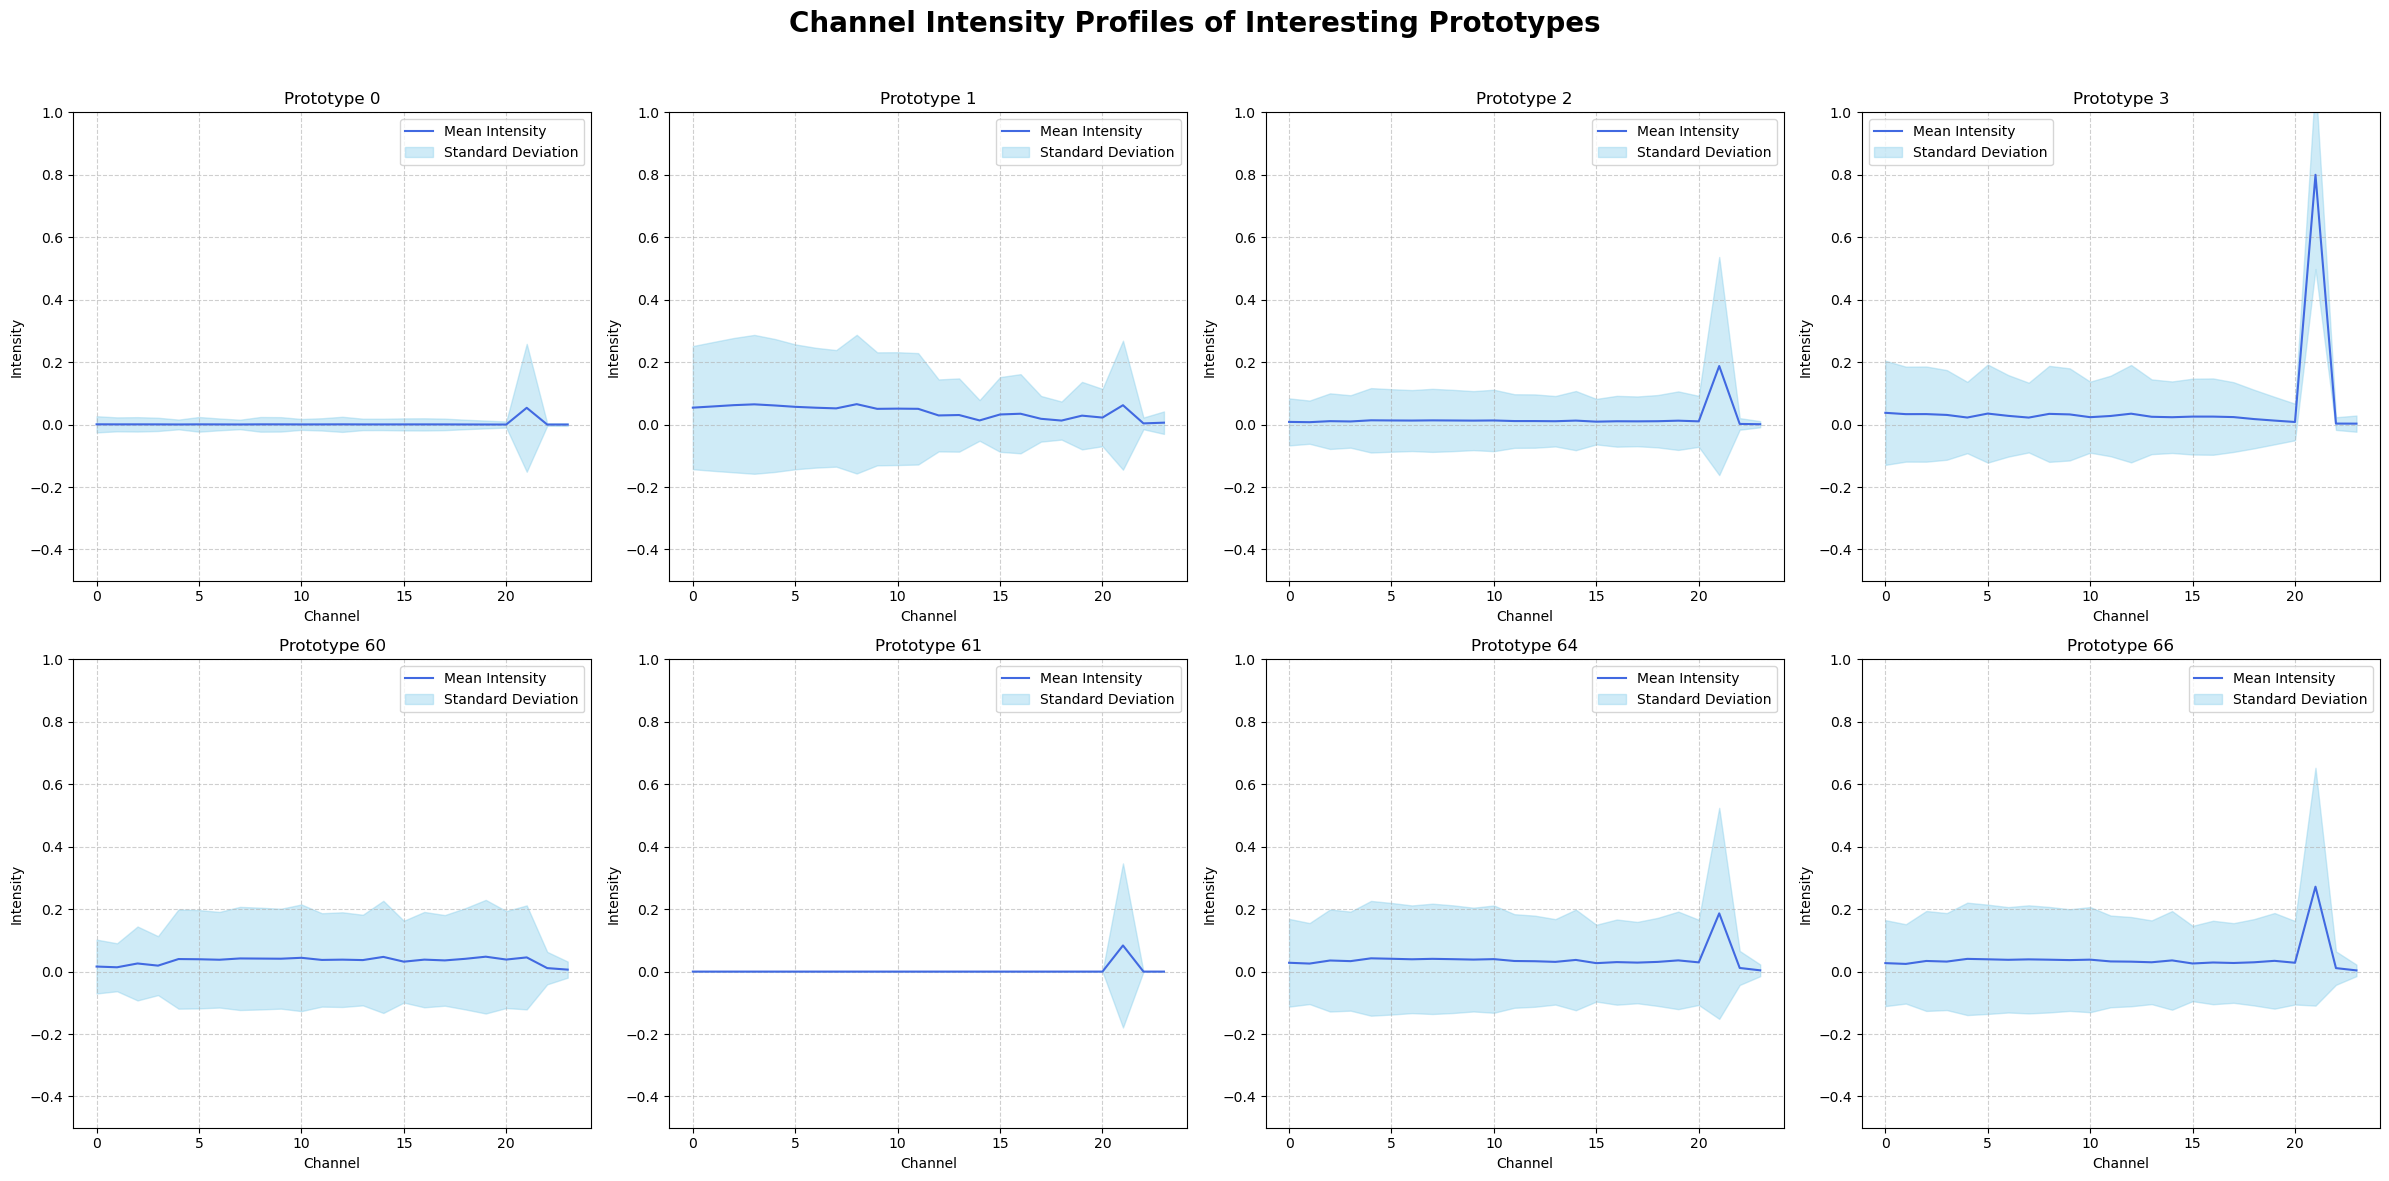

In [44]:
# Create subplots to visualize the channel stats for each interesting prototype
fig, axes = plt.subplots(2, 4, figsize=(24, 12))
# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each interesting prototype and its original index
for i, (proto_idx, prototype) in enumerate(zip(interesting_prototypes_i, interesting_prototypes)):
    # Calculate the mean and standard deviation for the channels
    mean, std = channel_stats(prototype)
    
    # Create an array representing the channel numbers for the x-axis
    channels = np.arange(len(mean))
    
    # Plot the mean intensity
    axes[i].plot(channels, mean, label='Mean Intensity', color='royalblue')
    
    # Create a shaded region for the standard deviation
    axes[i].fill_between(channels, mean - std, mean + std, color='skyblue', alpha=0.4, label='Standard Deviation')
    
    # Set the title and labels for the subplot
    axes[i].set_title(f'Prototype {proto_idx}')
    axes[i].set_xlabel('Channel')
    axes[i].set_ylabel('Intensity')
    axes[i].set_ylim(-0.5, 1.0)
    axes[i].legend()
    axes[i].grid(True, linestyle='--', alpha=0.6)

# Add a main title to the figure
plt.suptitle('Channel Intensity Profiles of Interesting Prototypes', fontsize=20, weight='bold')

# Adjust the layout to prevent titles and labels from overlapping
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Display the plots
plt.show()

# Retrieve H&E

Viz H&E for a prototype region.

In [58]:
def plot_hne(prototype_i):
    bounding_box = bounding_box_data[prototype_i]
    bounding_box_index = bounding_box.index
    bounds = bounding_box.bounds
    located_sample, index_within_sample, ids_to_include = locate_sample_and_index(train_ids, bounding_box_index, conf)
    hne_bound = get_hne_bound(located_sample, index_within_sample, ids_to_include, bounds)
    plt.imshow(hne_bound)
    plt.axis('off')
    plt.show()

 42%|████▏     | 8/19 [00:00<00:00, 103883.69it/s]


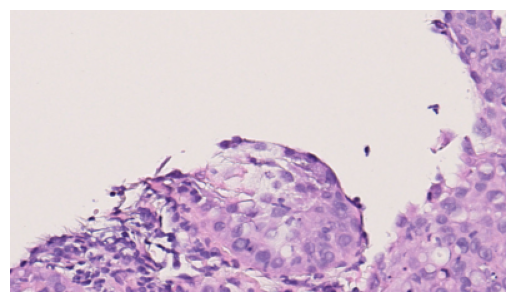

In [59]:
plot_hne(22)

 42%|████▏     | 8/19 [00:00<00:00, 116105.30it/s]


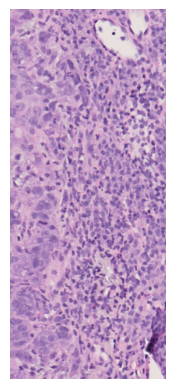

In [60]:
plot_hne(3)